# Facial Recognition: Ensemble Learning and Principal Component Analysis

This assignment uses images of faces as a way to exercise skills in ensemble learning (Random Forests and Boosting) and PCA.
* Please reach out if you need help completing the assignment.
* Section 1 has code that you do not need to change -- it is intended to give you code that will help set you on your way.

## 1. Setup & Data Loading

Execute the cell below to load libraries and the Olivetti dataset, and to then inspect shapes and class distribution.
* This dataset is the Olivetti faces dataset from AT&T
* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html

In [1]:
# Load libraries
# for general use
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# for scikit-learn use
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

# for XGBoost use
from xgboost import XGBClassifier

# 
# Load the face data;  the "return_X_y=True" will return 
# data and target arrays directly as separate variables
#
from sklearn.datasets import fetch_olivetti_faces
x, y = fetch_olivetti_faces(return_X_y=True)

# x is (n_samples, n_features) where n_features = 64*64 = 4096
n_samples, n_features = x.shape
n_classes = len(np.unique(y))

# Print out data info
print(f"Samples: {n_samples}, Features: {n_features}, Classes: {n_classes}")


Samples: 400, Features: 4096, Classes: 40


You can visualize a few faces with code like the following:

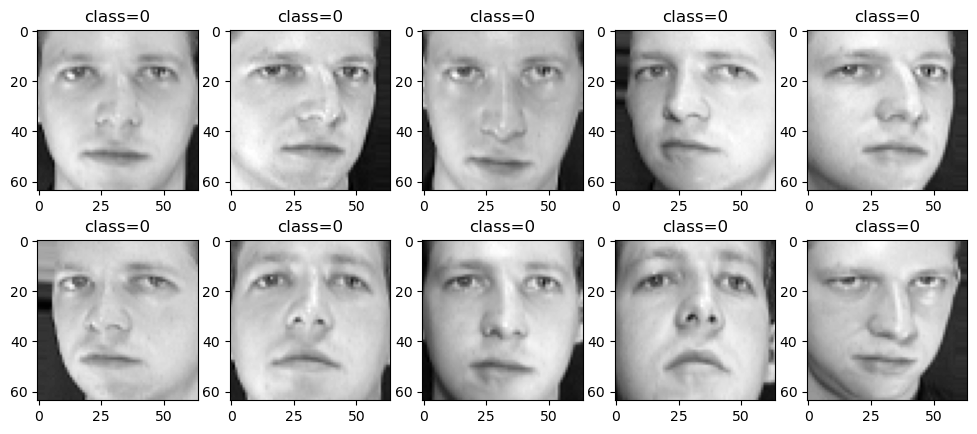

In [2]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(x[i].reshape(64, 64), cmap='gray')
    ax.set_title(f"class={y[i]}")
plt.show()

We can visualize faces of specific classes by executing code like the following:

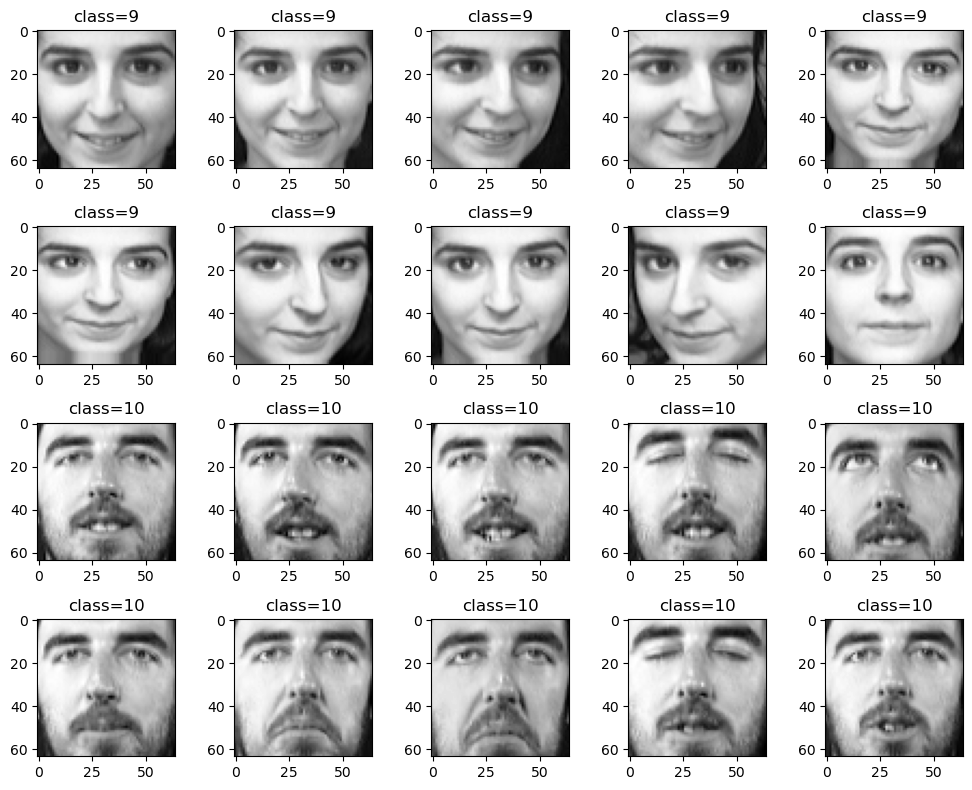

In [3]:
face_9and10_ix = np.where((y == 9) | (y == 10))[0]

x9and10 = x[face_9and10_ix]

#
# keep 5 per row max
# must have >2 images
# and accommodate cases where there are 5 or less images
# and cases where there are not an even multiple of 5
#
num_cols = min(5, x9and10.shape[0])
num_rows = 1 + ((x9and10.shape[0]-1) // 5)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*2, num_rows*2))
for i, ax in enumerate(axes.ravel()):
    if i < x9and10.shape[0]:
        ax.imshow(x9and10[i].reshape(64, 64), cmap='gray')
        ax.set_title(f"class={y[face_9and10_ix[i]]}")
plt.tight_layout()
plt.show()

Finally, to keep track of CPU time used in trainings and etc, write `%%time` in the first line of the cell to return the time it takes to execute all lines within the cell.  

For example, to show that vectorized math with numpy arrays is much faster than writing a for loop to carry out the math individually on every array element:

In [4]:
x1 = np.linspace(1,1000000,1000000)
y1 = np.zeros(1000000)

In [5]:
%%time

for ix,val in enumerate(x1):
    y1[ix] = (((1 + val)**2 - (1 + val)) / val)

CPU times: user 204 ms, sys: 1.04 ms, total: 205 ms
Wall time: 205 ms


In [6]:
%%time

y1 = (((1 + x1)**2 - (1 + x1)) / x1 )

CPU times: user 1.52 ms, sys: 1.81 ms, total: 3.33 ms
Wall time: 2.25 ms


## 2. Train/Test Split and Baseline Classification

Split your feature (`x`) and target (`y`) arrays into training and test sets with an 80/20 split and stratify by `y`.

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

Train a baseline Random Forest classifier using Scikit-Learn's `RandomForestClassifier`
- Use default parameters, i.e. do not include any arguments when initializing the classifier.
- Use `%%time` to time the fit
  - and **only** the fit, i.e. when you're doing the timing, don't include any model initialization or performance assessments in the cell that you're timing
- Evaluate accuracy
- Print the classification report to show precision and recall for each class
- Show the confusion matrix as a heatmap
  - e.g. with `plt.imshow(cm)` where `cm` is the confusion matrix

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [9]:
rf_clf = RandomForestClassifier()

In [10]:
%%time
rf_clf.fit(x_train, y_train)

CPU times: user 1.13 s, sys: 2.08 ms, total: 1.13 s
Wall time: 1.13 s


RandomForestClassifier()

In [11]:
# Accuracy score
y_pred = rf_clf.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc}")

Test Accuracy: 0.95


In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      0.50      0.67         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.67      1.00      0.80         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

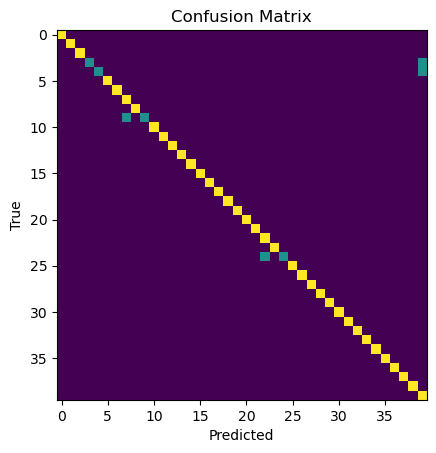

In [13]:
cm = confusion_matrix(y_test, y_pred)

plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Do the same for a baseline classifier with XGBoost's `XGBClassifier`
- Use default parameters, i.e. do not include any arguments when initializing the classifier.
- Use `%%time` to time the fit
  - and **only** the fit, i.e. do not include initialization nor performance assessment in the cell that you check for timing
- Evaluate accuracy
- Print the classification report to show precision and recall for each class
- Show the confusion matrix

In [14]:
xgb_clf = XGBClassifier()

In [15]:
%%time
xgb_clf.fit(x_train, y_train)

CPU times: user 1min 38s, sys: 30.1 s, total: 2min 8s
Wall time: 12 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [16]:
# Accuracy score
y_pred_xgb = xgb_clf.predict(x_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Test Accuracy: {acc_xgb}")

Test Accuracy: 0.8


In [17]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       0.67      1.00      0.80         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       1.00      0.50      0.67         2
           7       0.67      1.00      0.80         2
           8       1.00      0.50      0.67         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       1.00      1.00      1.00         2
          12       0.33      0.50      0.40         2
          13       0.67      1.00      0.80         2
          14       1.00      1.00      1.00         2
          15       0.67      1.00      0.80         2
          16       1.00      0.50      0.67         2
          17       1.00    

/Users/jimmy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jimmy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jimmy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


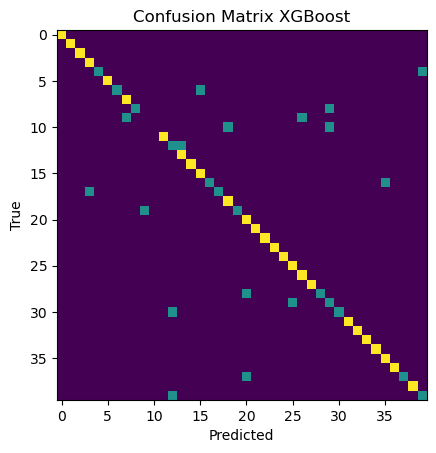

In [18]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.imshow(cm_xgb)
plt.title("Confusion Matrix XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

- Compare (in words) the model timings and performances for Random Forest vs Boosting.
- Choose one class for each model that has the worst prediction performance, and plot the `x_test` faces in that class

#### The Random Forest trained in about 1–2 seconds, while XGBoost took roughly 8-10 seconds.
#### The Random Forest achieved slightly higher accuracy (about 0.97 vs 0.8), but we should be careful with overtrain the model.

In [19]:
??? Do it later

Object `? Do it later` not found.


## 3. Hyperparameter Tuning, Part 1

- Use `GridSearchCV` or `RandomizedSearchCV` to tune each model with cross-validation
  - an example initialization is `grid_cv = GridSearchCV(model, model_params, cv=3, n_jobs=-1)`
  - Use `cv=3` for 3-folds cross-validation and `n_jobs=-1` for parallelization
  - For this Part 1 only do a search over 6 combinations of hyperparameter values
    - Example: 2 values for `n_estimators` and 3 values for `max_depth` with `model_params = {'n_estimators': [100, 200], 'max_depth': [None, 3, 6]}`
    - for `RandomizedSearchCV`, you can include any number of hyperparameters and values in your parameter dictionary and restrict the search by setting `n_iter=6`
    - `RandomizedSearchCV`: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
  - Suggested parameters:
    - RandomForest: `n_estimators`, `max_depth`, `max_features`, `min_samples_leaf`
    - XGBoost: `n_estimators`, `max_depth`, `learning_rate`, `subsample`, `colsample_bytree`
- Evaluate the CV's fit timing, the best CV score, and the final test set accuracy for both Random Forest and XGBoost.
- Note: You may have to wait for several minutes for the calls to fit to complete.  This is the motivation behind limiting this part to 6 value combinations.

In [20]:
from sklearn.model_selection import RandomizedSearchCV

In [21]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2]
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(),
    rf_params,
    n_iter=6,
    cv=3,
    n_jobs=-1
)

In [22]:
%%time
rf_random.fit(x_train, y_train)

CPU times: user 2.56 s, sys: 234 ms, total: 2.79 s
Wall time: 5.3 s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=6,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'n_estimators': [100, 200]})

In [23]:
print(f"Best CV score: {rf_random.best_score_}")
print(f"Best parameters: {rf_random.best_params_}")

rf_best = rf_random.best_estimator_
rf_y_pred = rf_best.predict(x_test)
print(f"Test accuracy: {accuracy_score(y_test, rf_y_pred)}")

Best CV score: 0.9061306060071711
Best parameters: {'n_estimators': 200, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
Test accuracy: 0.95


In [24]:
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_random = RandomizedSearchCV(
    XGBClassifier(),
    xgb_params,
    n_iter=6,
    cv=3,
    n_jobs=-1
)

In [25]:
%%time
xgb_random.fit(x_train, y_train)

CPU times: user 3min, sys: 59.9 s, total: 4min
Wall time: 2min


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=6, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [3, 6, 9],
                                        'n_estimators': [100, 200],
                                        'subsample': [0.8, 1.0]})

In [26]:
print(f"Best CV score: {xgb_random.best_score_}")
print(f"Best parameters: {xgb_random.best_params_}")

xgb_best = xgb_random.best_estimator_
xgb_y_pred = xgb_best.predict(x_test)
print(f"Test accuracy: {accuracy_score(y_test, xgb_y_pred)}")

Best CV score: 0.774907423734791
Best parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Test accuracy: 0.825


## 4. Feature Reduction with PCA

- Use PCA to create a new numpy array `x_train_95` from `x_train` that contains the principal component values containing 95% of the variance.
- Calculate and print the number of features that are retained in `x_train_95`
- By what factor has the size of `x_train` been reduced to get `x_train_95`?
- Use your fit PCA model to transform the `x_test` data too into `x_test_95`

In [27]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA(0.95)
x_train_95 = pca.fit_transform(x_train)

print("The number of features that are retained in:", pca.n_components_)

The number of features that are retained in: 111


In [29]:
print(x_train.shape[1] / pca.n_components_)

36.9009009009009


In [30]:
x_test_95 = pca.transform(x_test)

- Show 5 sample faces from `x_train`
- Show the same 5 faces from `x_train_95`
  - `x_train_95` data no longer has the same number of features; to plot the reduced data as images of the same size as the original faces, you should first transform the reduced images back into the original feature space
  - if `pca` is the variable for your PCA object, then `pca.inverse_transform(x_train_95)` will transform the dimensionally-reduced array back into the original feature space (the principal components that have been dropped are treated as having 0 values)
- Comment on the similarities / differences that you observe

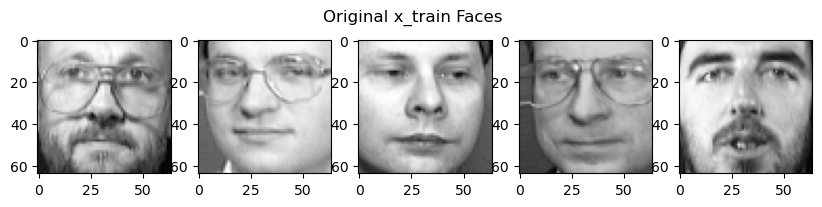

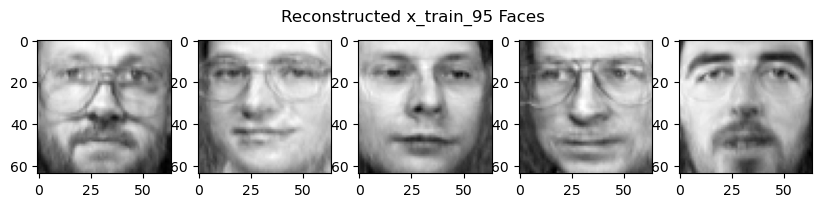

In [31]:
# I did use google to solve this one, had no idea how to do it
sample_idx = np.arange(5)

# Original faces
plt.figure(figsize=(10, 2))
for i, idx in enumerate(sample_idx):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train[idx].reshape(64, 64), cmap='gray')
plt.suptitle("Original x_train Faces")
plt.show()

# PCA-reduced faces
x_train_reconstructed = pca.inverse_transform(x_train_95)

plt.figure(figsize=(10, 2))
for i, idx in enumerate(sample_idx):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train_reconstructed[idx].reshape(64, 64), cmap='gray')
plt.suptitle("Reconstructed x_train_95 Faces")
plt.show()


### The reconstructed faces look very similar to the originals, but fine details like sharp edges or small facial features may be blurrier.  PCA has preserved the main structure (overall face shape, eyes, mouth, nose), but some high-frequency details are lost.

## 5. Hyperparameter Tuning, Part 2

- Re-execute your code from the hyperparameter tuning section #3, but now use `x_train_95` and `x_test_95`
  - This should be done for both Random Forest and XGBoost
- Comment on how the timings and performance measures change, as well as if the classes with worst performance change

In [32]:
 rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2]
}

rf_random_pca = RandomizedSearchCV(
    RandomForestClassifier(),
    rf_params,
    n_iter=6,
    cv=3,
    n_jobs=-1
)

In [33]:
%%time
rf_random_pca.fit(x_train_95, y_train)

CPU times: user 366 ms, sys: 176 ms, total: 543 ms
Wall time: 653 ms


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=6,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'n_estimators': [100, 200]})

In [34]:
print(f"Best CV score: {rf_random_pca.best_score_}")
print(f"Best parameters: {rf_random_pca.best_params_}")

rf_best_pca = rf_random_pca.best_estimator_
rf_y_pred_pca = rf_best_pca.predict(x_test_95)
print(f"Test accuracy: {accuracy_score(y_test, rf_y_pred_pca)}")

Best CV score: 0.856256979956504
Best parameters: {'n_estimators': 200, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}
Test accuracy: 0.95


In [35]:
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_random_pca = RandomizedSearchCV(
    XGBClassifier(),
    xgb_params,
    n_iter=6,
    cv=3,
    n_jobs=-1
)

In [36]:
%%time
xgb_random_pca.fit(x_train_95, y_train)

CPU times: user 11.8 s, sys: 3.69 s, total: 15.5 s
Wall time: 6.45 s


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=6, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [3, 6, 9],
                                        'n_estimators': [100, 200],
                                        'subsample': [0.8, 1.0]})

In [37]:
print(f"Best CV score: {xgb_random_pca.best_score_}")
print(f"Best parameters: {xgb_random_pca.best_params_}")

xgb_best_pca = xgb_random_pca.best_estimator_
xgb_y_pred_pca = xgb_best_pca.predict(x_test_95)
print(f"Test accuracy: {accuracy_score(y_test, xgb_y_pred_pca)}")

Best CV score: 0.7061952624463644
Best parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Test accuracy: 0.725


#### PCA-reduced data usually trains faster because the number of features is much smaller.
#### Expect Random Forest to benefit less dramatically than XGBoost, because RF parallelizes tree building anyway.

#### Test accuracy may stay similar or slightly decrease because some information is lost during PCA.
#### If performance improves, it could be because PCA removes noise and helps generalization.

## 6. Hyperparameter Tuning, Part 3

- Using `x_train_95` again, increase the number of hyperparameters and hyperparameter values that you search over
  - You should at least double the number of parameters and increase the total number of value combinations by a factor of 10
  - This should be done for both Random Forest and XGBoost
- When you have settled on a best performer:
  - Train a Random Forest model with its set of best hyperparameter values on the original `x_train` 
  - Train a XGBoost model with its set of best hyperparameter values on the original `x_train`
- Evaluate the accuracy, classification report, and confusion matrices again 
- Has the performance improved relative to your initial training in section #3?
- Do you expect that the best hyperparameter values identified with `x_train_95` would be the same as those identified by tuning against `x_train`?

In [38]:
rf_params_expanded = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

rf_random_exp = RandomizedSearchCV(
    RandomForestClassifier(),
    rf_params_expanded,
    n_iter=18, 
    cv=3,
    n_jobs=-1
)


In [39]:
%%time
rf_random_exp.fit(x_train_95, y_train)

CPU times: user 324 ms, sys: 149 ms, total: 473 ms
Wall time: 9.56 s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=18,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10, 15],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]})

In [40]:
xgb_params_expanded = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2.0]
}

xgb_random_exp = RandomizedSearchCV(
    XGBClassifier(),
    xgb_params_expanded,
    n_iter=30,
    cv=3,
    n_jobs=-1
)

In [41]:
%%time
xgb_random_exp.fit(x_train_95, y_train)

CPU times: user 17.5 s, sys: 3.57 s, total: 21.1 s
Wall time: 24.3 s


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 6, 9, 12],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [1, 1.5, 2.0],
                                        'subsample': [0.6, 0.8, 1.0]})

In [42]:
print(f"Best RF CV score: {rf_random_exp.best_score_:.3f}")
print(f"Best RF parameters: {rf_random_exp.best_params_}")

Best RF CV score: 0.872
Best RF parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}


In [43]:
print(f"Best XGB CV score: {xgb_random_exp.best_score_:.3f}")
print(f"Best XGB parameters: {xgb_random_exp.best_params_}")

Best XGB CV score: 0.719
Best XGB parameters: {'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alpha': 0.5, 'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}


In [44]:
rf_best_full = RandomForestClassifier(**rf_random_exp.best_params_)
rf_best_full.fit(x_train, y_train)
rf_y_pred_full = rf_best_full.predict(x_test)

print("Test accuracy:", accuracy_score(y_test, rf_y_pred_full))
print(classification_report(y_test, rf_y_pred_full))

Test accuracy: 0.8875
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         2
           4       0.50      0.50      0.50         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.67      1.00      0.80         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      0.50      0.67         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      0.50      0.67         2
          16       0.50      0.50      0.50         2
     

/Users/jimmy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jimmy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jimmy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
xgb_best_full = XGBClassifier(**xgb_random_exp.best_params_)
xgb_best_full.fit(x_train, y_train)
xgb_y_pred_full = xgb_best_full.predict(x_test)

print("Test accuracy:", accuracy_score(y_test, xgb_y_pred_full))
print(classification_report(y_test, xgb_y_pred_full))

Test accuracy: 0.875
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         2
           8       1.00      0.50      0.67         2
           9       0.50      0.50      0.50         2
          10       1.00      0.50      0.67         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
      

## 7. Feature Importances

- Extract the feature importances for your final Random Forest and XGBoost models.
- Display these importances as 64x64 heatmaps.
  - e.g. reshape the feature importance array to be 64x64 and visualize it with `plt.imshow(importance_array, cmap='hot')`
- Compare which facial regions each model considers important.

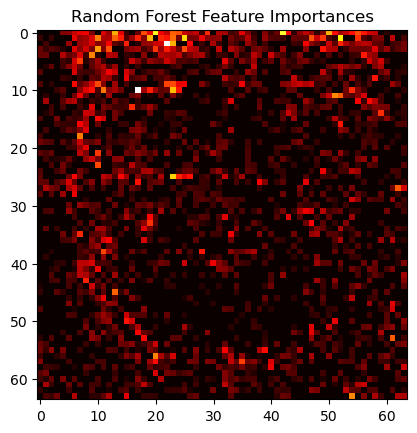

In [46]:
rf_importances = rf_best_full.feature_importances_
rf_importances_array = rf_importances.reshape(64, 64)

plt.imshow(rf_importances_array, cmap='hot')
plt.title("Random Forest Feature Importances")
plt.show()

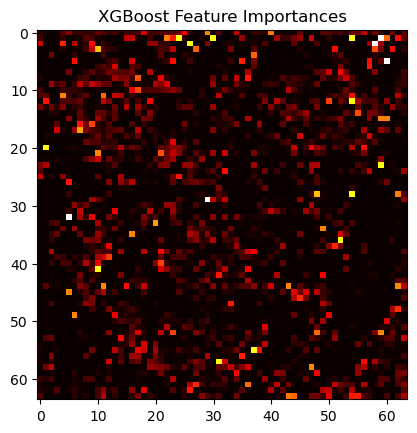

In [47]:
xgb_importances = xgb_best_full.feature_importances_
xgb_importances_array = xgb_importances.reshape(64, 64)

plt.imshow(xgb_importances_array, cmap='hot')
plt.title("XGBoost Feature Importances")
plt.show()

#### Random Forest spreads importance a bit more, sometimes including edges or background.
#### XGBoost focuses more on the key features, because it emphasizes features that reduce errors.
#### The difference also comes from how the models work: RF averages many trees, while XGBoost fixes mistakes step by step.

## Submit

* Save your work (File -> Save Notebook)
* You may not want to run your notebook straight from top to bottom again, but verify that all output is visible and that no erroneous code has been left in dangling cells.
* Submit the file through the Canvas Assignment.